### Search Engine with Tools and Agents

Reference: https://python.langchain.com/docs/integrations/tools/

### Tools
Tools are interfaces that an agent, chain or LLm can use to inteact with the world. They combine a few things:
- The name of the tool
- A description of what that tool is
- JSON schema of what the inputs to the tool are
- The function to call
- Whether the rsult of a tool should be returned directly to the user

Suppose the llm model which we are using currently was last traied on data till 2024, now i'm in 2025 and i want to get the new and latest information so for that purpose will create tools for getting latest information based on our usecase and these tools can be used with the help of agents

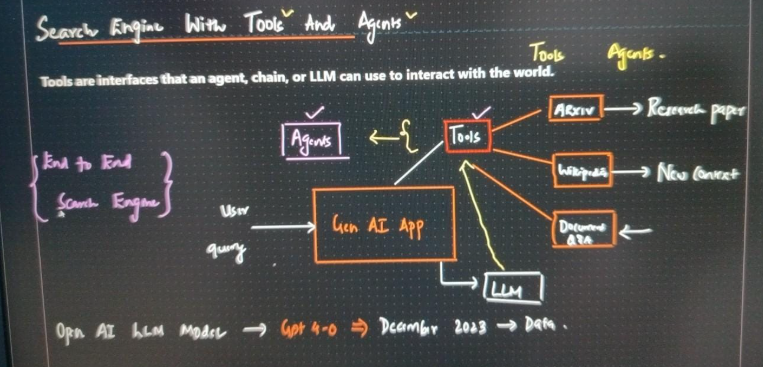

#### Tool creation
- in-build tools: for wikipedia, arxiv and many more
- creating custm tools

In [ ]:
# in-built tools
# pip install wikipedia
from langchain.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wiki_api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wikipedia=WikipediaQueryRun(api_wrapper=wiki_api_wrapper)
print(wikipedia)

wikipedia.run("mukesh ambani")

api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'c:\\Users\\srish\\anaconda3\\envs\\langchain\\lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=1, lang='en', load_all_available_meta=False, doc_content_chars_max=200)


'Page: Mukesh Ambani\nSummary: Mukesh Dhirubhai Ambani (born 19 April 1957) is an Indian billionaire businessman who is the chairman and managing director of Reliance Industries. He is the richest perso'

In [ ]:
# in-built tools
# pip install arxiv
from langchain.tools import ArxivQueryRun
from langchain_community.utilities import ArxivAPIWrapper

arxiv_api_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=230)
arxiv=ArxivQueryRun(api_wrapper=arxiv_api_wrapper)
arxiv.run("Generative AI")

'Published: 2021-03-29\nTitle: "Weak AI" is Likely to Never Become "Strong AI", So What is its Greatest Value for us?\nAuthors: Bin Liu\nSummary: AI has surpassed humans across a variety of tasks such as image\nclassification, playing '

In [9]:
# creating custom tools for RAG
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["HF_TOKEN"]=os.getenv("HF_TOKEN")
hug_embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

loader=WebBaseLoader("https://docs.smith.langchain.com/")
web_loader=loader.load()
txt_splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=200)
chunks=txt_splitter.split_documents(web_loader)
faiss_vector=FAISS.from_documents(chunks,hug_embeddings)
retriever=faiss_vector.as_retriever()

In [10]:
# in order to use the retriever as a tool we need to convert it in a tool
# now to create tool we need to convert this retriever into tool
from langchain.tools.retriever import create_retriever_tool

retriever_tool=create_retriever_tool(retriever,"LangSmith-Search","Search anything about Langsmith")
retriever_tool.name

'LangSmith-Search'

In [11]:
tools=[wikipedia,arxiv,retriever_tool]
tools

[WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'c:\\Users\\srish\\anaconda3\\envs\\langchain\\lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=1, lang='en', load_all_available_meta=False, doc_content_chars_max=200)),
 ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=1, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=230)),
 Tool(name='LangSmith-Search', description='Search anything about Langsmith', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x00000205C07B7700>, retriever=VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000020581B166

Reference: https://python.langchain.com/docs/concepts/agents/

### Agents
The core idea of agents is to use a language model to choose a sequence of actions to take. In chains, a sequence of actions is hardcoded. In agents, a language model is used as a reasoning to determine which actions to take and in which order.

suppose we have different tools which will perform different actions, agent will take all the tools and based on the user asked action agent will decide which tool to use to perform that particular action

#### run all the tools with agents and LLM

to combine tools with LLM and then exceute them, we need AgentExecutor

In [12]:
# llm
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

groq_llm=ChatGroq(model="Llama3-8b-8192")

Reference :https://python.langchain.com/v0.1/docs/modules/agents/agent_types/openai_functions_agent/

In [14]:
# new way of creating prompt template using hub
from langchain import hub

prompt=hub.pull("hwchase17/openai-functions-agent")
prompt.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a helpful assistant'), additional_kwargs={}),
 MessagesPlaceholder(variable_name='chat_history', optional=True),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={}),
 MessagesPlaceholder(variable_name='agent_scratchpad')]

In [15]:
# creating agents 
from langchain.agents import create_openai_tools_agent

agent=create_openai_tools_agent(groq_llm,tools,prompt)
agent

RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_to_openai_tool_messages(x['intermediate_steps']))
})
| ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages

In [16]:
# to run the agent, we need AgentExecutor
from langchain.agents import AgentExecutor

agent_executor=AgentExecutor(agent=agent,tools=tools,verbose=True)
agent_executor

AgentExecutor(verbose=True, agent=RunnableMultiActionAgent(runnable=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_to_openai_tool_messages(x['intermediate_steps']))
})
| ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag

In [17]:
agent_executor.invoke({'input':"tell me about langsmith"})



> Entering new AgentExecutor chain...

Invoking: `LangSmith-Search` with `{'query': 'Langsmith'}`


Get started with LangSmith | 🦜️🛠️ LangSmith

4. Log your first trace​
LangSmith + LangChain OSSYou don't need to use the LangSmith SDK directly if your application is built on LangChain/LangGraph (either Python and JS).See the how-to guide for tracing with LangChain here.
We provide multiple ways to log traces to LangSmith. Below, we'll highlight
how to use traceable(). See more on the Annotate code for tracing page.

Click the link printed out by your evaluation run to access the LangSmith experiments UI,
and explore the results of your evaluation.
Learn more about evaluation in the tutorials, conceptual guide, and how-to guides.

Skip to main contentGo to API DocsSearchRegionUSEUGo to AppQuick StartObservabilityEvaluationPrompt EngineeringDeployment (LangGraph Cloud)AdministrationSelf-hostingReferenceQuick StartOn this pageGet started with LangSmith
LangSmith is a platform for buildi

{'input': 'tell me about langsmith',
 'output': 'I\'ve received the output from the tool call for LangSmith-Search with query "Langsmith". It appears that LangSmith is a platform for building production-grade LLM (Large Language Model) applications, allowing users to closely monitor and evaluate their applications, and ship them quickly and with confidence.'}

In [19]:
agent_executor.invoke({'input':"what is machine learning"})



> Entering new AgentExecutor chain...

Invoking: `wikipedia` with `{'query': 'Machine learning'}`


Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and genThank you for the tool call result. Based on the provided information, I can continue answering your question.

Machine learning (ML) is a subset of artificial intelligence (AI) that involves training algorithms to learn from data and make predictions or decisions without being explicitly programmed. The algorithms learn by recognizing patterns and relationships in the data, which enables them to improve their performance over time.

Machine learning is a type of supervised or unsupervised learning, depending on whether the algorithm is trained on labeled or unlabeled data. Some common applications of machine learning include image and speech recognition, natural language processing, recom

{'input': 'what is machine learning',
 'output': "Thank you for the tool call result. Based on the provided information, I can continue answering your question.\n\nMachine learning (ML) is a subset of artificial intelligence (AI) that involves training algorithms to learn from data and make predictions or decisions without being explicitly programmed. The algorithms learn by recognizing patterns and relationships in the data, which enables them to improve their performance over time.\n\nMachine learning is a type of supervised or unsupervised learning, depending on whether the algorithm is trained on labeled or unlabeled data. Some common applications of machine learning include image and speech recognition, natural language processing, recommender systems, and predictive modeling.\n\nThere are several types of machine learning, including:\n\n1. Supervised learning: This type of learning involves training an algorithm on labeled data, where the correct output is provided for each input

In [20]:
agent_executor.invoke({'input':"what's the paper 1706.03762 about?"})



> Entering new AgentExecutor chain...

Invoking: `arxiv` with `{'query': '1706.03762'}`


Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction m
Invoking: `wikipedia` with `{'query': 'Attention Is All You Need'}`


Page: Attention Is All You Need
Summary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deThe paper "Attention Is All You Need" introduced a new deep learning architecture called the Transformer, which is primarily used for machine translation. The Transformer model relies solely on self-attention mechanisms, without relying on convolutional or recurrent neural network (RNN) components. This model has been widely adopted and has achieved state-of-the-art results in many natural language proce

{'input': "what's the paper 1706.03762 about?",
 'output': 'The paper "Attention Is All You Need" introduced a new deep learning architecture called the Transformer, which is primarily used for machine translation. The Transformer model relies solely on self-attention mechanisms, without relying on convolutional or recurrent neural network (RNN) components. This model has been widely adopted and has achieved state-of-the-art results in many natural language processing tasks.'}